# Demonstrate behavior of successor representation model

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tesser import network
from tesser import tasks
from tesser import model
from tesser import figures

bids_dir = os.environ['TESSER_BIDS']
model_dir = Path(os.environ['TESSER_FIGURES']) / 'model'
fig_dir = model_dir / 'demo_sr'
os.makedirs(fig_dir, exist_ok=True)

## Load structure learning and inference task data

In [2]:
struct = tasks.load_struct(bids_dir)
induct = tasks.load_induct(bids_dir)
induct = tasks.label_induct(induct)

# matrix of item pairs in the same community
nodes = network.node_info()
community = nodes['community'].to_numpy()
same_community = (community == community[:, np.newaxis]).astype(float)

## Compare association strength between models

In [3]:
colors = figures.get_induct_colors()
palette = [c for p in colors.values() for c in p]

### SR model

In [4]:
# load best-fitting parameters
model_name = 'sr-comm-gqw_a10'
fit_file = model_dir / f'fit_{model_name}' / 'fit.csv'
params = model.load_fit_params(fit_file)

# get association strength of cue to target and lure
strength_dfs = []
for subject, struct_subj in struct.groupby('subject'):
    M = model.learn_struct_sr(
        struct_subj, params['gamma'], params['alpha'], 21
    )
    induct_subj = induct.query(f'subject == {subject}')
    strength_df = model.strength_induct(induct_subj, M)
    strength_dfs.append(strength_df)
strength = pd.concat(strength_dfs, axis=0)

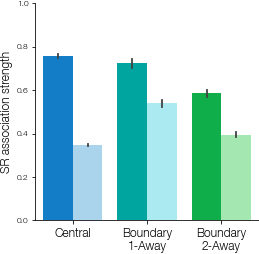

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.barplot(
    data=strength, x='trial_type', hue='item', y='strength', ax=ax
)
ax.set(
    ylim=(0, 1),
    ylabel='SR association strength',
    xlabel='',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
)
ax.tick_params(axis='x', labelsize='large');
ax.get_legend().remove()
for patch, color in zip(ax.patches, palette):
    patch.set_facecolor(color)
fig.savefig(fig_dir / 'sr_strength.pdf')

### Community model

In [6]:
strength = model.strength_induct(induct, same_community)

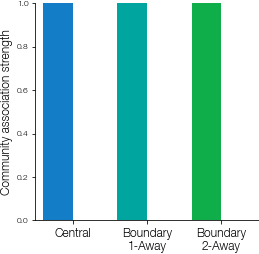

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.barplot(
    data=strength, x='trial_type', hue='item', y='strength', ax=ax
)
ax.set(
    ylim=(0, 1),
    ylabel='Community association strength',
    xlabel='',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
)
ax.tick_params(axis='x', labelsize='large');
ax.get_legend().remove()
for patch, color in zip(ax.patches, palette):
    patch.set_facecolor(color)
fig.savefig(fig_dir / 'comm_strength.pdf')

## Examine effect of gamma on inference fit

### SR model

In [8]:
fit_dir = model_dir / 'fit_sr-g_a10'
model_def = model.load_model_def(fit_dir / 'parameters.json')
param = model.load_fit_params(fit_dir / 'fit.csv', drop_stats=False)

gammas = np.linspace(0, 1, 100)
log_likelihood = model.sweep_param(
    struct,
    induct,
    param,
    'gamma',
    gammas,
    sim1_spec=model_def['sim1_spec'],
    sim2_spec=model_def['sim2_spec'],
)

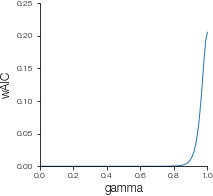

In [9]:
aic = model.aic(log_likelihood, param['n'], param['k'])
waic = model.waic(aic, axis=0)
res = pd.DataFrame(
    {'gamma': gammas, 'logl': log_likelihood, 'aic': aic, 'waic': waic}
)
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=res, x='gamma', y='waic', clip_on=False, ax=ax)
ax.set(ylim=(0, 0.25), xlim=(0, 1), ylabel='wAIC', xlabel='gamma')
fig.savefig(fig_dir / 'waic_gamma_sr.pdf')

### Hybrid model

In [10]:
fit_dir = model_dir / 'fit_sr-comm-gqw_a10'
model_def = model.load_model_def(
    fit_dir / 'parameters.json', sim2=same_community
)
param = model.load_fit_params(fit_dir / 'fit.csv', drop_stats=False)

gammas = np.linspace(0, 1, 100)
log_likelihood = model.sweep_param(
    struct,
    induct,
    param,
    'gamma',
    gammas,
    sim1_spec=model_def['sim1_spec'],
    sim2_spec=model_def['sim2_spec'],
    question_param=model_def['question_param'],
)

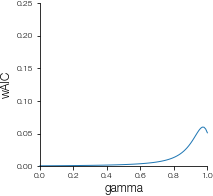

In [11]:
aic = model.aic(log_likelihood, param['n'], param['k'])
waic = model.waic(aic, axis=0)
res = pd.DataFrame(
    {'gamma': gammas, 'logl': log_likelihood, 'aic': aic, 'waic': waic}
)
fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=res, x='gamma', y='waic', clip_on=False, ax=ax)
ax.set(ylim=(0, 0.25), xlim=(0, 1), ylabel='wAIC', xlabel='gamma')
fig.savefig(fig_dir / 'waic_gamma_sr-comm.pdf')

## Run learning with parameter sweeps

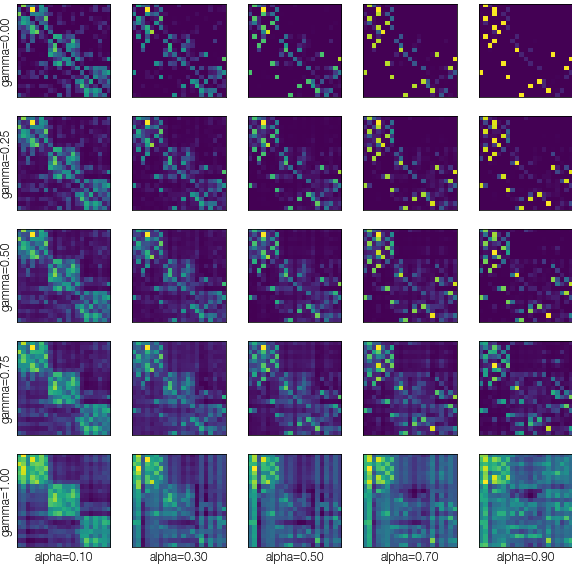

In [12]:
struct_s1 = struct.query('subject == 103')
ind = np.hstack((np.arange(17, 21), np.arange(0, 17)))

gamma = np.linspace(0, 1, 5)
alpha = np.linspace(0.1, 0.9, 5)
ng = len(gamma)
na = len(alpha)
fig, ax = plt.subplots(ng, na, sharex=True, sharey=True, figsize=(10, 10))
for i, g in enumerate(gamma):
    for j, a in enumerate(alpha):
        M = model.learn_struct_sr(struct_s1, g, a, 21)
        ax[i, j].matshow(M[np.ix_(ind, ind)])
        ax[i, j].set(xticks=[], yticks=[])
        ax[i, j].spines['top'].set_visible(True)
        ax[i, j].spines['right'].set_visible(True)
for i, g in enumerate(gamma):
    ax[i, 0].set_ylabel(f'gamma={g:.2f}')
for j, a in enumerate(alpha):
    n = len(gamma) - 1
    ax[n, j].set_xlabel(f'alpha={a:.2f}')
    
fig.savefig(fig_dir / 'param_sweep.pdf')